In [539]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score,recall_score
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import warnings
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. compose import ColumnTransformer
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt  
from wordcloud import WordCloud

In [3]:
warnings.filterwarnings('ignore')

In [4]:
base_url = 'https://api.pushshift.io/reddit/search/'

In [513]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',200)

### Pulling in Posts from Reddit Pushshift API

In [6]:
def pull_posts(base_url,subreddit,length):
    data_pulls = pd.DataFrame()
    before = 1650821963
    for i in range(length):
        parameters = {'subreddit': subreddit,
                  'size': 100,
                  'is_self' : True,
                  'before': before}
        try:
            response = requests.get(base_url+'submission/',parameters)
            if response.status_code != 200:
                print('request failed')
            else:
                data = response.json()
                posts = data['data']
                posts = pd.DataFrame(posts)
                data_pulls = pd.concat([data_pulls,posts])
                time.sleep(5)
                before = data_pulls['created_utc'].iloc[-1]
        except:
            print("Exception: {}".format(type(exception).__name__))
            print("Exception message: {}".format(exception))
            time.sleep(15)
    return data_pulls

#futurology_pulls = pull_posts(base_url,'futurology',289)
#futurology_pulls.to_csv('futurology_pull.csv',index=False)

#collapse_pulls = pull_posts(base_url,'collapse',288)
#collapse_pulls.to_csv('collapse_pull.csv',index=False)

In [7]:
df_fut = pd.read_csv('futurology_pull.csv')
df_col = pd.read_csv('collapse_pull.csv')

In [8]:
len(df_col), len(df_fut)

(28741, 28876)

### Checking for duplicates

In [10]:
df_fut = df_fut.drop_duplicates()
df_col = df_col.drop_duplicates()

### Dropping unnecessary columns

In [11]:
df_fut_cut = df_fut[['subreddit','title']]
df_col_cut = df_col[['subreddit','title']]

### Combining Dataframes

In [12]:
df_comb = pd.concat([df_col_cut,df_fut_cut])

In [13]:
df_comb.shape

(57617, 2)

### Shuffling and Splitting Dataset into Holdout

In [14]:
df_comb = df_comb.sample(frac=1,random_state=2)

In [15]:
df_holdout = df_comb[0:11523]
X_holdout = df_holdout['title']
y_holdout = df_holdout['subreddit']

In [16]:
df_main = df_comb[11523:]

In [17]:
df_holdout.shape, df_main.shape

((11523, 2), (46094, 2))

Using 30% of the dataset for initial analysis.

In [18]:
df_sample = df_main.sample(frac=0.3,random_state=2)

In [19]:
df_sample['subreddit'].value_counts(normalize=True)

Futurology    0.500434
collapse      0.499566
Name: subreddit, dtype: float64

In [20]:
df_sample['subreddit'].value_counts()

Futurology    6920
collapse      6908
Name: subreddit, dtype: int64

### TTS

In [21]:
X = df_sample['title']
y = df_sample['subreddit']

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2,stratify=y)

### Baseline Null

The below is our baseline score, against which the accuracy metrics of the model will be assessed. As this is the dataset's percentage of the majority class, the model will need to demonstrate the ability to choose the correct subreddit of origin at a higher rate than merely choosing 'Futurology' each time.

In [23]:
dc = DummyClassifier()
dc.fit(X_train,y_train)
dc.predict(X_test)
dc.score(X_test,y_test)

0.5004339022273647

### Tokenize/Lemmatize

In [24]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

### Creating Own List of Stopwords

Creating my own list of stopwords in an effort to cut through some of the noise the model may encounter from words that should ultimately not be important towards its classification of the posts. The words future/collapse, as well as the various forms the subreddits themselves may be referenced in the posts included in the stopwords so as not to give the model an advantage.

In [535]:
my_stop_words=['?',',','.','(',')',':','!','u','\'','i','are','that','the','on','and','is','to','a','of',\
               'in','what','for','will','you','it','be','this','with','do','n\'t','-','\'s','\'','an',\
               '`','.',',','u','/r/futurology','/r/collapse','~','e','g','’','``','=','o','de','r/collapse','r/futurology',\
               'we','how','about','have','can','if','all','or','would','by','our','why','not','your','year','when',\
               'could','there','like','from','...','an','ha','haha','hahaha','[]','[',']','so','new','now','doe',\
               'my','more','just','any','but','who','at','some','me',';','they','no','yes','out','should','get',\
               'most','s','than','up','one','wa','make','here','thing','#','$','got','&','*','where','anyone',\
               'futurology','future','\'''','%','🤔','🤙','😈','🔮','/r/futorology','“','😜','🗿','•',\
              '】해외베팅','】아시안커넥트/아시안커넥트 주소/아시안커넥트','】아시안커넥트/아시안커넥트','】스포츠토토','】메이저','【','》','《','☎1',\
              'collapsing','futurist','collapse',\
              'post-collapse','region','collapsed','link','in-depth',\
               'futuristic']

### Count Vectorize

In [26]:
cvec = CountVectorizer(strip_accents='unicode',stop_words=my_stop_words,ngram_range=(1,2),tokenizer=lemma_tokenizer)
cvec.fit(X_train)
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

X_train_cv = pd.DataFrame(X_train_cv.A,columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(X_test_cv.A,columns=cvec.get_feature_names_out())



### TF-IDF Vectorize

In [27]:
tfi = TfidfVectorizer(strip_accents='unicode',stop_words=my_stop_words,ngram_range=(1,2),tokenizer=lemma_tokenizer)
tfi.fit(X_train)
X_train_tfi = tfi.transform(X_train)
X_test_tfi = tfi.transform(X_test)

X_train_tfi = pd.DataFrame(X_train_tfi.A,columns=tfi.get_feature_names_out())
X_test_tfi = pd.DataFrame(X_test_tfi.A,columns=tfi.get_feature_names_out())

### Label Encoding Y

In [28]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [29]:
y_train_le.mean()

0.4995660977726352

Collapse = 1

The most commonly features in the vectorized model is reviewed in order to add words to the custom stopwords list.

### Reviewing Most Frequent Features

In [30]:
X_train_cv.sum().sort_values(ascending=False).head(25)

think             454
''                441
world             427
people            393
human             379
climate           353
change            333
technology        254
ai                253
going             227
climate change    218
time              199
life              191
next              187
need              178
thought           178
see               177
society           164
good              153
job               152
question          152
global            150
car               149
their             148
help              148
dtype: int64

### Naive Bayes

Running Multinomial Naive Bayes on lemmatized, countvectorized data. Model not shown dropped lemmatizer and model worsened.

In [99]:
pipenb = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer)),
    ('nb',MultinomialNB())   
    ])

pipenb.fit(X_train,y_train_le)
pipenb.score(X_train,y_train_le),pipenb.score(X_test,y_test_le)

(0.898177610645068, 0.798090830199595)

In [100]:
pipenb_params = {
    'cv__ngram_range' : [(1,1), (1,2), (2,2), (1,3), (2,3)],
    'cv__min_df': [1,2,3],
    'cv__max_df': [0.6,0.5,0.4],
}

In [102]:
gsnb = GridSearchCV(pipenb,param_grid=pipenb_params)
gsnb.fit(X_train,y_train_le)
gsnb.score(X_train,y_train_le),gsnb.score(X_test,y_test_le)

(0.9684697714781603, 0.8021405843216662)

In [103]:
gsnb.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.6, ngram_range=(1, 2),
                                 stop_words=['?', ',', '.', '(', ')', ':', '!',
                                             'u', "'", 'i', 'are', 'that',
                                             'the', 'on', 'and', 'is', 'to',
                                             'a', 'of', 'in', 'what', 'for',
                                             'will', 'you', 'it', 'be', 'this',
                                             'with', 'do', "n't", ...],
                                 strip_accents='unicode',
                                 tokenizer=<function lemma_tokenizer at 0x7f82d49a2940>)),
                ('nb', MultinomialNB())])

The gridsearch yielded an improved model, with an accuracy score of 80.21%.

Scoring The TF-IDF vectorized data on Gaussian Naive Bayes. Multinomial Naive Bayes is suited for count-vectorized, Gaussian to data vectorized using TF-IDF.

In [108]:
gnb = GaussianNB()

gnb.fit(X_train_tfi,y_train_le)
gnb.score(X_train_tfi,y_train_le),gnb.score(X_test_tfi,y_test_le)

(0.9865008195930961, 0.6901938096615563)

The Gaussian Naive Bayes performs much worse than the Multinomial.

### Logistic, Count Vectorized

Running fairly basic Logistic Regression. CV data. Performs worse than Naive Bayes.

In [111]:
logregpipe = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

logregpipe.fit(X_train,y_train_le)
logregpipe.score(X_train,y_train_le),logregpipe.score(X_test,y_test_le)

(0.9300935300356764, 0.7839166907723459)

The model does not perform as well as Naive Bayes. Conducting gridsearch to tune hyperparamters.

In [114]:
logregpipe_params = {
    'cv__ngram_range' : [(1,1), (1,2), (2,2), (1,3), (2,3)],
    'cv__min_df': [1,2,3],
    'cv__max_df': [0.4,0.5,0.6],
    'lr__C': [.1,1,10,100]
}

In [115]:
gslogreg = GridSearchCV(logregpipe,param_grid=logregpipe_params)
gslogreg.fit(X_train,y_train)
gslogreg.score(X_train,y_train), gslogreg.score(X_test,y_test)

(0.9846687879664449, 0.7914376627133353)

In [116]:
gslogreg.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.4, ngram_range=(1, 2),
                                 stop_words=['?', ',', '.', '(', ')', ':', '!',
                                             'u', "'", 'i', 'are', 'that',
                                             'the', 'on', 'and', 'is', 'to',
                                             'a', 'of', 'in', 'what', 'for',
                                             'will', 'you', 'it', 'be', 'this',
                                             'with', 'do', "n't", ...],
                                 strip_accents='unicode',
                                 tokenizer=<function lemma_tokenizer at 0x7f82d49a2940>)),
                ('lr', LogisticRegression(C=1, max_iter=10000))])

The gridsearch produces a model that tunes several paramters and produces an accuracy of 79.14%. Not as strong as Naive Bayes model.

In [129]:
logregpipe2 = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer,max_df=0.4,ngram_range=(1, 2),max_features=60000)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

logregpipe2.fit(X_train,y_train_le)
logregpipe2.score(X_train,y_train_le),logregpipe2.score(X_test,y_test_le)

(0.9835117153601388, 0.7885449811975701)

Efforts to improve score via implementing max features were unsuccessful.

### Logistic, TF-IDF

Running similar analysis, with TF-IDF vectorizing.

In [130]:
lgtpipe = Pipeline(
    [
    ('tf',TfidfVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

lgtpipe.fit(X_train,y_train_le)
lgtpipe.score(X_train,y_train_le),lgtpipe.score(X_test,y_test_le)

(0.8961527335840324, 0.7943303442291004)

A fairly standard model performs better than the gridsearched count-vectorized model, with a 79.43% accuracy.

Building gridsearch to try to build better model.

In [134]:
lgtpipe_params = {
    'tf__min_df': [1, 2, 3,4],
    'tf__max_df': [.4, .5],
    'tf__ngram_range': [[1,1], [1,2], [2,2], [1,3]],
    'lr__C': [.1,1,10]
}

In [135]:
gslgt = GridSearchCV(lgtpipe,param_grid=lgtpipe_params)
gslgt.fit(X_train,y_train)
gslgt.score(X_train,y_train), gslgt.score(X_test,y_test)

(0.9595988814964805, 0.7931732716227944)

In [136]:
gslgt.best_estimator_

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.4, ngram_range=[1, 3],
                                 stop_words=['?', ',', '.', '(', ')', ':', '!',
                                             'u', "'", 'i', 'are', 'that',
                                             'the', 'on', 'and', 'is', 'to',
                                             'a', 'of', 'in', 'what', 'for',
                                             'will', 'you', 'it', 'be', 'this',
                                             'with', 'do', "n't", ...],
                                 tokenizer=<function lemma_tokenizer at 0x7f82d49a2940>)),
                ('lr', LogisticRegression(C=1, max_iter=10000))])

In [150]:
lgtpipe2 = Pipeline(
    [
    ('tf',TfidfVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,max_df=0.4,ngram_range=[1, 3],max_features=69000)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

lgtpipe2.fit(X_train,y_train_le)
lgtpipe2.score(X_train,y_train_le),lgtpipe2.score(X_test,y_test_le)

(0.9407964516440074, 0.795776684986983)

After running gridsearch, a better model is identified with a max feature parameter of 69,000. This is the best Logistic Regression model, but not as strong as the Naive Bayes.

### KNN Model

Running a KNN model with tuned parameters.

In [178]:
pipeknn = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,ngram_range=[1,3],max_df=0.5,min_df=3)),
    ('knc', KNeighborsClassifier(n_neighbors=3,weights='distance'))
    ])

pipeknn.fit(X_train,y_train_le)
pipeknn.score(X_train,y_train_le),pipeknn.score(X_test,y_test_le)

(0.9765692797223026, 0.6421752964998554)

The KNN model performs worse than any model previously seen in this analysis.

### Decision Tree Classifier

Running a Decision Tree Classifier with tuned parameters.

In [181]:
pipedtc = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,ngram_range=[1,3],max_df=0.5)),
    ('dtc', DecisionTreeClassifier(random_state=2,max_depth=10))
    ])

pipedtc.fit(X_train,y_train_le)
pipedtc.score(X_train,y_train_le),pipedtc.score(X_test,y_test_le)

(0.592710442580272, 0.5840323980329766)

This model performs worse than KNN.

### Random Forest, Count Vectorized

Running a Random Forest model with count vectorized data and tuned hyperparameters. 

In [205]:
piperfc = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,ngram_range=(1,2),max_df=0.5)),
    ('rfc', RandomForestClassifier(random_state=2,n_estimators=400,min_samples_split=4,max_depth=None))
    ])

piperfc.fit(X_train,y_train_le)
piperfc.score(X_train,y_train_le),piperfc.score(X_test,y_test_le)

(0.993732523382509, 0.7755279143766272)

Fairly strong, not as strong as Bayes or strongest logistic.

### Random Forest, TF-IDF Vectorized

Running  Random Forest model using the TF-IDF vectorization and tuned parameters.

In [210]:
piperfct = Pipeline(
    [
    ('tf',TfidfVectorizer(stop_words=my_stop_words,ngram_range=[1,2],max_df=0.5,tokenizer=lemma_tokenizer)),
    ('rfc', RandomForestClassifier(random_state=2,min_samples_split=5,n_estimators=400,max_depth=None))
    ])

piperfct.fit(X_train,y_train_le)
piperfct.score(X_train,y_train_le),piperfct.score(X_test,y_test_le)

(0.9945039051200463, 0.7639571883135666)

Model does not perform as strongly as the count vectorized model.

### Ada Booster

Running a tuned model using AdaBoost.

In [227]:
pipeada = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,ngram_range=[1,2],max_df=0.7,tokenizer=lemma_tokenizer,max_features=45000)),
    ('abc', AdaBoostClassifier(random_state=2,n_estimators=2000))
    ])

pipeada.fit(X_train,y_train_le)
pipeada.score(X_train,y_train_le),pipeada.score(X_test,y_test_le)

(0.9201619901648829, 0.7526757304020827)

Model does not perform as well as RFC, Bayes, or Logistic.

Running similar analysis with TF-IDF data.

In [225]:
pipeada = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,ngram_range=[1,1],max_df=0.7,tokenizer=lemma_tokenizer,max_features=45000)),
    ('abc', AdaBoostClassifier(random_state=2,n_estimators=2000))
    ])

pipeada.fit(X_train,y_train_le)
pipeada.score(X_train,y_train_le),pipeada.score(X_test,y_test_le)

(0.9493780734741105, 0.7243274515475846)

Model does not perform as well as with count vectorized data.

### Ensemble Analysis

Ensemble model built with Count Vectorized data, combining Logistic Regression, Multinomial Naive Bayes, and Random Forest Classifier.

In [31]:
vr1 = VotingClassifier(
    [('lr',LogisticRegression(max_iter=10000)),
     ('mnb', MultinomialNB()),
     ('rfc', RandomForestClassifier(random_state=2,min_samples_split=4,n_estimators=250)),
      ],
)

vr1.fit(X_train_cv,y_train_le)
vr1.score(X_train_cv,y_train_le),vr1.score(X_test_cv,y_test_le)

(0.9860187060071353, 0.7963552212901359)

This model was strong, but is slightly worse than the Naive Bayes Mode.

In [31]:
vr2 = VotingClassifier(
    [('lr',LogisticRegression(max_iter=10000)),
     ('mnb', MultinomialNB()),
     ('rfc', RandomForestClassifier(random_state=2,min_samples_split=4,n_estimators=250)),
      ],
)

vr2.fit(X_train_tfi,y_train_le)
vr2.score(X_train_tfi,y_train_le),vr2.score(X_test_tfi,y_test_le)

(0.9743515572268826, 0.8038761932311252)

Using TF-IFD vectorized data improves the model to 80.39% accuracy on the test set. This is the best model that has been produced thus far.

### Revisiting Naive Bayes

Running a tuned model of Multinomial Naive Bayes with Count Vectroized data, trigrams, and max features of 70,000.

In [268]:
pipenb2 = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer,min_df=1,max_df=0.6,max_features=70000,ngram_range=(1,3))),
    ('nb',MultinomialNB())   
    ])

pipenb2.fit(X_train,y_train_le)
pipenb2.score(X_train,y_train_le),pipenb2.score(X_test,y_test_le)

(0.9662520489827403, 0.8278854498119756)

This is the best model that has yet been produced.

Running tuned model of Multinomial Naive Bayes, using TF-IDF, with bigrams and max features of 64,000.

In [534]:
pipenb3 = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 2),max_df=.4,tokenizer=lemma_tokenizer,max_features=64000)),
    ('nb',MultinomialNB(alpha=1))   
    ])

pipenb3.fit(X_train,y_train_le)
pipenb3.score(X_train,y_train_le),pipenb3.score(X_test,y_test_le)

(0.9765692797223026, 0.8319352039340469)

This is the best model, with 83.19% accuracy on test set. This will be the model we proceed with.

### Further Analysis - Feature Importance and Adding StopWords

Identifying the features having the largest impact on the model.

In [287]:
imps = pipenb3.named_steps['nb'].feature_log_prob_[1,:] - pipenb3.named_steps['nb'].feature_log_prob_[0,:]

nb_feat_imp = pd.DataFrame(imps.T,
            index=pipenb3.named_steps['tfi'].get_feature_names_out().T,
            columns=['feature imps'])

#code help from: https://donernesto.github.io/blog/notes-on-multinomial-naive-bayes/

These are the 25 features strongest associated with the 'futurology' subreddit. From here, additional words referencing the future will be added to stop-words. This will hurt performance but create less biased model.

In [283]:
nb_feat_imp.sort_values(by='feature imps').head(25)

,feature imps
blockchain,-4.125974
virtual reality,-3.454863
futuristic,-3.372531
quantum,-3.263616
vr,-3.257406
self-driving,-3.211137
immortality,-3.189682
ai,-3.159704
futurology,-3.069689
future technology,-3.005939


These are the 25 features strongest associated with the 'collapse' subreddit. From here, additional words referencing collapse will be added to stop-words. This will hurt performance but create less biased model.

In [284]:
nb_feat_imp.sort_values(by='feature imps').tail(25)

,feature imps
post collapse,2.627059
collapse inevitable,2.639505
ipcc,2.664450
guy mcpherson,2.684158
during collapse,2.699562
region in-depth,2.720034
mcpherson,2.763819
region,2.828579
economic collapse,2.829883
observation,2.831654


### Rerunning model after Additional StopWords Added

Running best model with updated stopwords list.

In [389]:
pipenb4 = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 2),max_df=.4,tokenizer=lemma_tokenizer,max_features=64000)),
    ('nb',MultinomialNB())   
    ])

pipenb4.fit(X_train,y_train_le)
pipenb4.score(X_train,y_train_le),pipenb4.score(X_test,y_test_le)

(0.9708803394079645, 0.8044547295342783)

As expected, we see the performance fall to 80.44% accuracy on the test set.

The model would perform at 82.21% accuracy if the stopwords had not been aded.

### Running Model on Larger Dataset

Now running the model on the larger dataset, from which the 30% was extracted to perform the previous analysis above. Train/test split and label encoding done to facilitate this.

In [390]:
X2 = df_main['title']
y2 = df_main['subreddit']
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,random_state=2,stratify=y2)

y_train_le2 = le.fit_transform(y_train2)
y_test_le2 = le.transform(y_test2)

In [391]:
pipenb4.fit(X_train2,y_train_le2)
pipenb4.score(X_train2,y_train_le2),pipenb4.score(X_test2,y_test_le2)

(0.9091698004049754, 0.8277507809788268)

The performance on the largeer test dataset is to 82.77% accuracy. The model got better as it saw more data.

In [392]:
imps2 = pipenb4.named_steps['nb'].feature_log_prob_[1,:] - pipenb4.named_steps['nb'].feature_log_prob_[0,:]
nb_feat_imp2 = pd.DataFrame(imps2.T,
            index=pipenb4.named_steps['tfi'].get_feature_names_out().T,
            columns=['feature imps'])

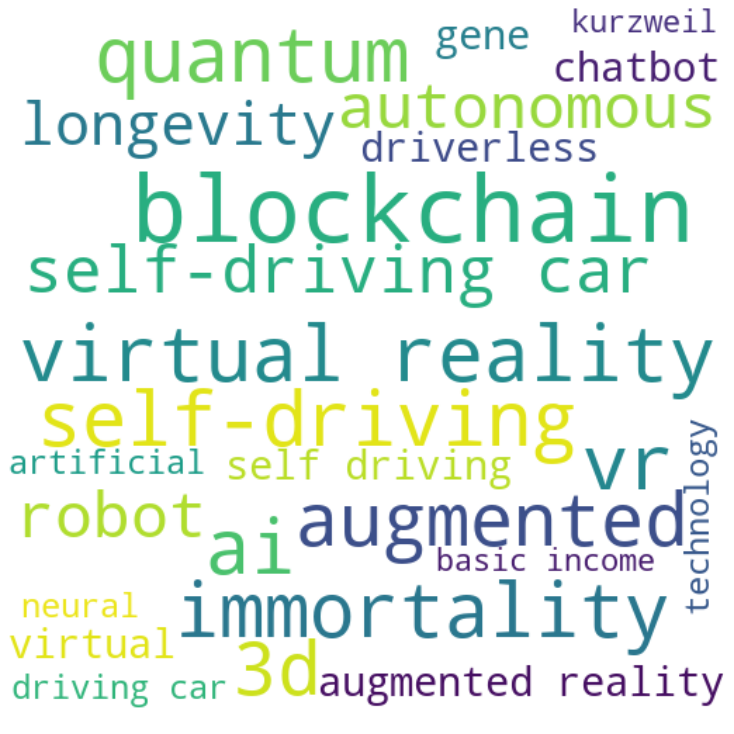

In [557]:
fut_25 = nb_feat_imp2.sort_values(by='feature imps').head(25)

ft25_dict = dict(zip(fut_25.index.tolist(), abs(fut_25['feature imps']).tolist()))


word_cloud = WordCloud(width = 512, height = 512, background_color='white',colormap='viridis').generate_from_frequencies(ft25_dict)
plt.figure(figsize=(20,10),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


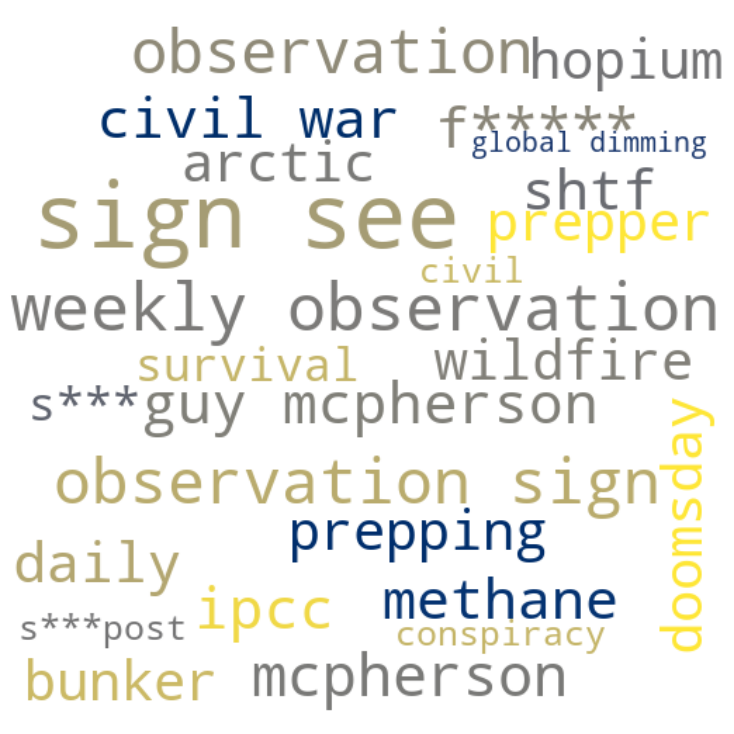

In [566]:
col_25 = nb_feat_imp2.sort_values(by='feature imps').tail(25).sort_values(by='feature imps',ascending=False)
col_25.rename(index={'fucked':'f*****','shit':'s***','shitpost':'s***post'},inplace=True)
col25_dict = dict(zip(col_25.index.tolist(), abs(col_25['feature imps']).tolist()))

word_cloud = WordCloud(width = 512, height = 512, background_color='white',colormap='cividis').generate_from_frequencies(col25_dict)
plt.figure(figsize=(20,10),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


### Running Model on the holdout set

https://vitalflux.com/hold-out-method-for-training-machine-learning-model/

In [395]:
y_holdout.value_counts(normalize=True)

collapse      0.503341
Futurology    0.496659
Name: subreddit, dtype: float64

In [396]:
y_holdout_le = le.transform(y_holdout)

In [397]:
pipenb4.fit(X_train2,y_train_le2)
pipenb4.score(X_holdout,y_holdout_le)

0.8170615291156816

The model performs with 81.7% accuracy on the holdout set, which exceeds baseline rate of 50%. This model meets the intended goal of performing better than the baseline.

## Analysis of Results

### Confusion Matrix

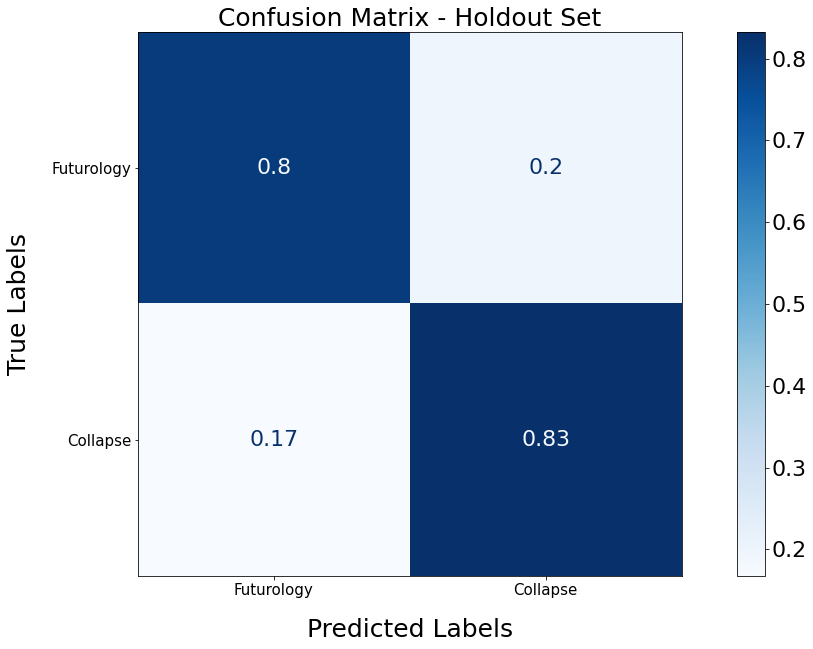

In [581]:
f = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
ax = plt.subplot()
ConfusionMatrixDisplay.from_estimator(pipenb4,X_holdout,y_holdout_le,cmap='Blues',ax=ax,normalize='true')
ax.set_xlabel('Predicted Labels',labelpad=20,fontsize=25)
ax.set_ylabel('True Labels',labelpad=20,fontsize=25)
ax.set_title('Confusion Matrix - Holdout Set',fontsize=25)
ax.xaxis.set_ticklabels(['Futurology', 'Collapse'],fontsize=15)
ax.yaxis.set_ticklabels(['Futurology', 'Collapse'],fontsize=15);

Better rate picking Collapse than futurology.

Rate of Futurology predicted as collapse: 20%

Rate of Collapse predicted as futurology: 17%


### Misclassification DataFrame (via Holdout Set)

Creating a datframe for title in the holdout set that the model incorrectly predicted for further analysis.

In [464]:
test_preds = pipenb4.predict(X_holdout)
misclass = X_holdout.copy()
misclass = pd.DataFrame(misclass,columns=['title'])


misclass['true_class'] = y_holdout
misclass['pred_class'] = ['collapse' if i == 1 else 'Futurology' for i in test_preds]
misclassified = misclass[misclass['true_class'] != misclass['pred_class']]



In [528]:
#misclassified[450:500]

In [591]:
nb_feat_imp2.loc['quantum']

feature imps   -3.209838
Name: quantum, dtype: float64

In [ ]:
Actually Futurology:
Is anything at all being done to deal with climate change and the water crisis now and in the future?
Is countryside land going to have more (due to global population growth) or less (due to vertical farming) value in the next 10 - 20 years?
Having a backup body in the future would mean Murderers would not be in jail for that long considering your not even dead.

Actually Collapse:
Have you guys noticed the huge machine who owns us all?
Autonomous vehicles, how can they not be classified as possibly-autonomous weaponry by the UN
Will life in outer space save us?

Actually Futurology
What affect do you think the Trump Presidency will have on issues with a Futurology theme?

Having a backup body in the future would mean Murderers would not be in jail for that long considering your not even dead.

### Analyzing Length of Post

In [491]:
misclassified['title_length'] = [len(i) for i in misclassified['title']]
df_holdout['title_length'] = [len(i) for i in df_holdout['title']]

print(misclassified['title_length'].median(),df_holdout['title_length'].median())
misclassified['title_length'].mean(),df_holdout['title_length'].mean()

50.0 56.0


(62.789373814041745, 68.07107524082271)

The misclassified posts are shorter on average, and have a lower median size post than the average for the holdout set.

### Reviewing the TF-IFD Vectorized Data for Misclassification DataFrame

In [472]:
misct = misclassified['title']

In [486]:
tfmisc = TfidfVectorizer(stop_words='english',strip_accents='unicode',ngram_range=(1, 2),tokenizer=lemma_tokenizer,min_df=3)
misc_tf = tfmisc.fit_transform(misct)
misc_tf = pd.DataFrame(misc_tf.A,columns=tfmisc.get_feature_names_out())

In [487]:
misc_tf.sum().sort_values(ascending=False).head(50)

?             159.453911
.              88.937026
collapse       86.824093
,              78.173684
future         65.837466
!              34.884581
's             34.714307
:              33.198302
-              29.819462
world          28.948082
)              25.933963
(              24.635506
year           23.872635
n't            23.514993
think          23.086772
...            22.175423
new            21.581500
people         21.241451
like           21.226346
collapse ?     20.206705
change         19.489470
``             18.753722
need           18.311131
u              18.308235
human          17.648292
''             17.589661
climate        17.211895
’              17.020341
just           16.918566
future ?       16.665928
time           16.591416
doe            15.922575
good           15.160060
life           14.735966
futurology     14.208623
ha             13.809914
question       13.654970
know           13.409176
best           13.173678
thing          13.122150


The words that show up most frequently in the misclassifcation, as one might expect, are the words that were included in our stopwords to keep from giving the model an advantage: future, collapse, futurology.

## Future Research

### Analysis Using SelfText and Title

I quickly analyzed how the model would perform if the available self-text was included in the analysis. Ran model without much additional tuning, adjusted to include trigrams, and allow for 80,000 features. Went through same process of splitting data into train,validation, and holdout sets.

In [449]:
pipenb5 = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 3),tokenizer=lemma_tokenizer,max_features=80000)),
    ('nb',MultinomialNB())   
    ])

In [457]:
df_fut_cut2 = df_fut[['selftext','subreddit','title']]
df_col_cut2 = df_col[['selftext','subreddit','title']]
df_comb2 = pd.concat([df_col_cut2,df_fut_cut2])
df_comb2['selftext'] = [' ' if i == '[removed]' else i for i in df_comb2['selftext']]
df_comb2['alltext'] = df_comb2['selftext'] + df_comb2['title']
df_comb2 = df_comb2.sample(frac=1,random_state=2)
df_comb2 = df_comb2.dropna()
df_comb2 = df_comb2.drop_duplicates()
df_holdout2 = df_comb2[0:11523]
df_main2 = df_comb2[11523:]

X3 = df_main2['alltext']
y3 = df_main2['subreddit']



In [458]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,random_state=2,stratify=y3)

y_train_le3 = le.fit_transform(y_train3)
y_test_le3 = le.transform(y_test3)

In [459]:
y_test3.value_counts(normalize=True)

collapse      0.5123
Futurology    0.4877
Name: subreddit, dtype: float64

Generated baseline of 51.23% for comparison.

In [460]:
pipenb5.fit(X_train3,y_train_le3)
pipenb5.score(X_train3,y_train_le3),pipenb5.score(X_test3,y_test_le3)

(0.8996458087367178, 0.8474203120513066)

The model performed with 84.74% accuracy on the this data.

In [461]:
X_hold2 = df_holdout2['alltext']
y_hold2 = df_holdout2['subreddit']
y_hold2_le = le.transform(y_hold2)

pipenb5.score(X_hold2,y_hold2_le)

0.8492580057276751

The model similarly scored 84.93% accuracy on the holdout data.

The next steps in improving then model would be to further explore how well the model might perform if we further finetune using this additional data.